In [1]:
import math
import time
import gc
import os

import numpy as np
import pandas as pd
import lightgbm as lgb

from contextlib import contextmanager
from glob import glob
from itertools import combinations
from pathlib import Path

from sklearn.metrics import roc_auc_score

In [2]:
dtypes = {
    'ip': 'uint32',
    'app': 'uint16',
    'device': 'uint16',
    'os': 'uint16',
    'channel': 'uint16',
    'is_attributed': 'uint8',
    'click_id': 'uint32',
    'hour': 'uint8',
}

In [3]:
feature_include = tuple([
#     'COUNT(clicks)_',
#     'COUNT(clicks WHERE is_attributed = True)_',
    'PERCENT_TRUE(clicks.is_attributed)_',
#     'AVG_TIME_BETWEEN(clicks.click_time)_',
#     'AVG_TIME_BETWEEN(clicks.click_time WHERE is_attributed = True)_',

#     'SKEW(clicks.hour.COUNT(clicks))_',
     'SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_',
#     'SKEW(clicks.hour.AVG_TIME_BETWEEN(clicks.click_time))_',
#     'STD(clicks.hour.COUNT(clicks))_app_7days',
     'STD(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_',
#     'STD(clicks.hour.AVG_TIME_BETWEEN(clicks.click_time))_',
#     'MEDIAN(clicks.hour.COUNT(clicks))_app_7days',
#     'MEDIAN(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_',
#     'MEDIAN(clicks.hour.AVG_TIME_BETWEEN(clicks.click_time))_',
])

In [9]:
predictors = [
'hour',
'PERCENT_TRUE(clicks.is_attributed)_app_7days',
'SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_app_7days',
'STD(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_app_7days',
'PERCENT_TRUE(clicks.is_attributed)_os_7days',
'SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_os_7days',
'STD(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_os_7days',
'PERCENT_TRUE(clicks.is_attributed)_channel_7days',
'SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_channel_7days',
'STD(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_channel_7days',
'PERCENT_TRUE(clicks.is_attributed)_ip_7days',
'SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_ip_7days',
'STD(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_ip_7days',
'PERCENT_TRUE(clicks.is_attributed)_hour_7days',
'PERCENT_TRUE(clicks.is_attributed)_app_device_7days',
'SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_app_device_7days',
'STD(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_app_device_7days',
'PERCENT_TRUE(clicks.is_attributed)_app_os_7days',
'SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_app_os_7days',
'STD(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_app_os_7days',
'PERCENT_TRUE(clicks.is_attributed)_app_channel_7days',
'SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_app_channel_7days',
'STD(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_app_channel_7days',
'PERCENT_TRUE(clicks.is_attributed)_app_hour_7days',
'SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_app_hour_7days',
'STD(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_app_hour_7days',
'PERCENT_TRUE(clicks.is_attributed)_device_os_7days',
'SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_device_os_7days',
'STD(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_device_os_7days',
'PERCENT_TRUE(clicks.is_attributed)_device_channel_7days',
'SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_device_channel_7days',
'STD(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_device_channel_7days',
'PERCENT_TRUE(clicks.is_attributed)_device_ip_7days',
'SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_device_ip_7days',
'STD(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_device_ip_7days',
'PERCENT_TRUE(clicks.is_attributed)_device_hour_7days',
'SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_device_hour_7days',
'STD(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_device_hour_7days',
'PERCENT_TRUE(clicks.is_attributed)_os_channel_7days',
'SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_os_channel_7days',
'STD(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_os_channel_7days',
'PERCENT_TRUE(clicks.is_attributed)_os_hour_7days',
'SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_os_hour_7days',
'STD(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_os_hour_7days',
'PERCENT_TRUE(clicks.is_attributed)_channel_hour_7days',
'SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_channel_hour_7days',
'STD(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_channel_hour_7days',
'PERCENT_TRUE(clicks.is_attributed)_ip_hour_7days',
'SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_ip_hour_7days',
'STD(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_ip_hour_7days',
'PERCENT_TRUE(clicks.is_attributed)_app_device_os_7days',
'SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_app_device_os_7days',
'STD(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_app_device_os_7days',
'PERCENT_TRUE(clicks.is_attributed)_app_device_channel_7days',
'SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_app_device_channel_7days',
'STD(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_app_device_channel_7days',
'PERCENT_TRUE(clicks.is_attributed)_app_device_hour_7days',
'SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_app_device_hour_7days',
'STD(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_app_device_hour_7days',
'PERCENT_TRUE(clicks.is_attributed)_app_os_channel_7days',
'SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_app_os_channel_7days',
'STD(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_app_os_channel_7days',
'PERCENT_TRUE(clicks.is_attributed)_app_os_hour_7days',
'SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_app_os_hour_7days',
'STD(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_app_os_hour_7days',
'PERCENT_TRUE(clicks.is_attributed)_app_channel_hour_7days',
'SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_app_channel_hour_7days',
'STD(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_app_channel_hour_7days',
'PERCENT_TRUE(clicks.is_attributed)_device_os_channel_7days',
'SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_device_os_channel_7days',
'STD(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_device_os_channel_7days',
'PERCENT_TRUE(clicks.is_attributed)_device_os_hour_7days',
'SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_device_os_hour_7days',
'STD(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_device_os_hour_7days',
'PERCENT_TRUE(clicks.is_attributed)_device_channel_hour_7days',
'SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_device_channel_hour_7days',
'STD(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_device_channel_hour_7days',
'PERCENT_TRUE(clicks.is_attributed)_os_channel_hour_7days',
'SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_os_channel_hour_7days',
'STD(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_os_channel_hour_7days',
]
exclude = [
# 'PERCENT_TRUE(clicks.is_attributed)_os_7days',
#        'PERCENT_TRUE(clicks.is_attributed)_device_os_channel_7days',
#        'PERCENT_TRUE(clicks.is_attributed)_hour_7days',
#        'PERCENT_TRUE(clicks.is_attributed)_app_channel_hour_7days',
#        'PERCENT_TRUE(clicks.is_attributed)_channel_hour_7days',
#        'PERCENT_TRUE(clicks.is_attributed)_device_channel_hour_7days',
#        'PERCENT_TRUE(clicks.is_attributed)_device_channel_7days',
#        'PERCENT_TRUE(clicks.is_attributed)_os_hour_7days',
#        'PERCENT_TRUE(clicks.is_attributed)_app_os_7days',
#        'PERCENT_TRUE(clicks.is_attributed)_device_hour_7days',
#        'PERCENT_TRUE(clicks.is_attributed)_device_os_hour_7days',
#        'PERCENT_TRUE(clicks.is_attributed)_os_channel_7days',
#        'PERCENT_TRUE(clicks.is_attributed)_app_7days',
#        'PERCENT_TRUE(clicks.is_attributed)_device_os_7days',
#        'PERCENT_TRUE(clicks.is_attributed)_app_hour_7days',
#        'PERCENT_TRUE(clicks.is_attributed)_app_device_hour_7days',
#        'PERCENT_TRUE(clicks.is_attributed)_channel_7days',
#        'PERCENT_TRUE(clicks.is_attributed)_app_device_channel_7days',
]

for x in predictors:
    if x in exclude:
        predictors.remove(x)

In [5]:
target_entities_init = ['app', 'device', 'os', 'channel', 'ip', 'hour']
target_entities = []

for t in combinations(target_entities_init, 1):
#     if 'device' in t: continue
    target_entities.append(t[0])
for t in combinations(target_entities_init, 2):
#     if 'ip' in t: continue
    target_entities.append(list(t))
for t in combinations(target_entities_init, 3):
#     if 'ip' in t: continue
    target_entities.append(list(t))
# for t in combinations(target_entities_init, 4):
#     target_entities.append(list(t))

target_entities.remove('device')
target_entities.remove(['app', 'ip'])
target_entities.remove(['os', 'ip'])
target_entities.remove(['channel', 'ip'])
target_entities.remove(['app', 'os', 'ip'])
target_entities.remove(['app', 'device', 'ip'])
target_entities.remove(['app', 'channel', 'ip'])
target_entities.remove(['app', 'ip', 'hour'])
target_entities.remove(['device', 'os', 'ip'])
target_entities.remove(['device', 'channel', 'ip'])
target_entities.remove(['device', 'ip', 'hour'])
target_entities.remove(['os', 'channel', 'ip'])
target_entities.remove(['os', 'ip', 'hour'])
target_entities.remove(['channel', 'ip', 'hour'])

In [6]:
def remove(df, columns):
    if type(columns) is list: columns = tuple(columns)
    to_drop = [c for c in df.columns if not c.startswith(columns)]
    if len(to_drop) > 0: df.drop(columns=to_drop, inplace=True)
    for c in df.columns:
        df[c] = df[c].astype(np.float32)
    return df

def split(df, target_entity):
    if type(target_entity) == str:
        df[target_entity] = df.index
    elif len(target_entity) == 2:
        df[target_entity[0]], df[target_entity[1]] = df.index.str.split('_').str
        df[target_entity[0]] = df[target_entity[0]].astype(dtypes[target_entity[0]])
        df[target_entity[1]] = df[target_entity[1]].astype(dtypes[target_entity[1]])
    elif len(target_entity) == 3:
        df[target_entity[0]], df[target_entity[1]], df[target_entity[2]] = df.index.str.split('_').str
        df[target_entity[0]] = df[target_entity[0]].astype(dtypes[target_entity[0]])
        df[target_entity[1]] = df[target_entity[1]].astype(dtypes[target_entity[1]])
        df[target_entity[2]] = df[target_entity[2]].astype(dtypes[target_entity[2]])
    return df

def combine_features(df, features_prefix, feature_suffix):
    for target_entity in target_entities:
        target_entity_name = target_entity if type(target_entity) == str else "_".join(target_entity)
        feature_files = sorted(glob(f"../data/interim/features/{target_entity_name}/{features_prefix}*{feature_suffix}.hdf.compress"))
        assert len(feature_files) > 0
        for feature_file in feature_files:
            df_feature = pd.read_hdf(feature_file)
            df_feature = remove(df_feature, feature_include)
            df_feature = split(df_feature, target_entity)
            df = pd.merge(df, df_feature, how='left', left_on=target_entity, right_on=target_entity)
            del df_feature
            gc.collect()
    return df

In [7]:
force = True
cache_train = '../data/cache/train_lgbm_2017-11-08.hdf.compress'
feature_suffix = 'attributed6'
train_feature_prefix = 'features_2017-11-07_1700'
valid_feature_prefix = 'features_2017-11-08_1700'

if not Path(cache_train).exists() or force:
    print("Train cache doesn't exist, creating")
    if Path(cache_train).exists(): os.remove('../data/cache/train_lgbm_2017-11-08.hdf.compress')
    train_summary = pd.read_csv('../data/interim/day_hour_train.csv')
    start_row = train_summary[(train_summary['day'] == 7) & (train_summary['hour'] == 16)]['start'].values[0]
    stop_row = train_summary[(train_summary['day'] == 8) & (train_summary['hour'] == 16)]['end'].values[0]
    df_train = pd.read_hdf('../data/raw/train.hdf.compress', start=start_row, stop=stop_row)
    df_train['hour'] = df_train['click_time'].dt.hour
    df_train = combine_features(df_train, train_feature_prefix, feature_suffix)
    df_train.to_hdf(cache_train, 'train', mode='w', complib='blosc', fletcher32=True, complevel=9)

#     train_summary = pd.read_csv('../data/interim/day_hour_train.csv')
#     start_row = train_summary[(train_summary['day'] == 7) & (train_summary['hour'] == 16)].index[0]
#     stop_row = train_summary[(train_summary['day'] == 8) & (train_summary['hour'] == 16)].index[0]
#     for i in range(start_row, stop_row + 1):
#         row = train_summary.iloc[i].to_dict()
#         df_train = pd.read_hdf('../data/raw/train.hdf.compress', start=row['start'], stop=row['end'])
#         df_train['hour'] = df_train['click_time'].dt.hour
#         df_train = combine_features(df_train, train_feature_prefix, feature_suffix)
#         df_train.to_hdf(cache_train, 'train', format='table', mode='a', append=True, complib='blosc', fletcher32=True, complevel=9)
    
#     df_train = pd.read_hdf(cache_train)
else:
    df_train = pd.read_hdf(cache_train)

cache_val = '../data/cache/validate_lgbm_2017-11-09.hdf.compress'
if not Path(cache_val).exists() or force:
    print("Validation cache doesn't exist, creating")
    train_summary = pd.read_csv('../data/interim/day_hour_train.csv')
    start_row = train_summary[(train_summary['day'] == 9) & (train_summary['hour'] == 4)]['start'].values[0]
    stop_row = train_summary[(train_summary['day'] == 9) & (train_summary['hour'] == 6)]['end'].values[0]
    df_val = pd.read_hdf('../data/raw/train.hdf.compress', start=start_row, stop=stop_row)
    df_val['hour'] = df_val['click_time'].dt.hour
    df_val = combine_features(df_val, valid_feature_prefix, feature_suffix)
    df_val.to_hdf(cache_val, 'train', mode='w', complib='blosc', fletcher32=True, complevel=9)
else:
    df_val = pd.read_hdf(cache_val)

gc.collect()

Train cache doesn't exist, creating
Validation cache doesn't exist, creating


7

In [8]:
for c in df_train.columns:
#     if c.startswith("PERCENT_TRUE"):
        print(f"'{c}',")

'ip',
'app',
'device',
'os',
'channel',
'click_time',
'attributed_time',
'is_attributed',
'hour',
'PERCENT_TRUE(clicks.is_attributed)_app_7days',
'SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_app_7days',
'STD(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_app_7days',
'PERCENT_TRUE(clicks.is_attributed)_os_7days',
'SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_os_7days',
'STD(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_os_7days',
'PERCENT_TRUE(clicks.is_attributed)_channel_7days',
'SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_channel_7days',
'STD(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_channel_7days',
'PERCENT_TRUE(clicks.is_attributed)_ip_7days',
'SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_ip_7days',
'STD(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_ip_7days',
'PERCENT_TRUE(clicks.is_attributed)_hour_7days',
'PERCENT_TRUE(clicks.is_attributed)_app_device_7days',
'SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attributed))_app_device_7days',
'ST

In [61]:
for c in predictors:
#     if c.startswith("COUNT(clicks)_app_device_channel_7days"):
        print(f"'{c}',")

'hour',
'PERCENT_TRUE(clicks.is_attributed)_os_7days',
'PERCENT_TRUE(clicks.is_attributed)_ip_7days',
'PERCENT_TRUE(clicks.is_attributed)_app_device_7days',
'PERCENT_TRUE(clicks.is_attributed)_app_channel_7days',
'PERCENT_TRUE(clicks.is_attributed)_device_os_7days',
'PERCENT_TRUE(clicks.is_attributed)_device_ip_7days',
'PERCENT_TRUE(clicks.is_attributed)_os_channel_7days',
'PERCENT_TRUE(clicks.is_attributed)_channel_hour_7days',
'PERCENT_TRUE(clicks.is_attributed)_ip_hour_7days',
'PERCENT_TRUE(clicks.is_attributed)_app_device_os_7days',
'PERCENT_TRUE(clicks.is_attributed)_app_device_hour_7days',
'PERCENT_TRUE(clicks.is_attributed)_app_os_channel_7days',
'PERCENT_TRUE(clicks.is_attributed)_app_os_hour_7days',
'PERCENT_TRUE(clicks.is_attributed)_device_os_channel_7days',
'PERCENT_TRUE(clicks.is_attributed)_device_channel_hour_7days',
'PERCENT_TRUE(clicks.is_attributed)_os_channel_hour_7days',


In [10]:
params = {
    'boosting_type': 'dart',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
#     'num_leaves': 2,
    'max_depth': -1,
    'min_data_in_leaf': 10,
    'max_bin': 16,
#     'bagging_fraction': 0.7,
#     'bagging_freq': 1,
#     'feature_fraction': 0.7,
#     'min_sum_hessian_in_leaf': 5,
#     'bin_construct_sample_cnt': 200000,
#     'min_split_gain': 0,
#     'reg_alpha': 1,
#     'reg_lambda': 1,
   # 'nthread': 8,
    'verbose': 0,
   'is_unbalance': True,
#     'scale_pos_weight':200,
    'use_missing': False,
    'zero_as_missing': True,    
}

In [11]:
dtrain = lgb.Dataset(
    df_train[predictors].values,
    label=df_train['is_attributed'].values,
    feature_name=predictors,
)

dvalid = lgb.Dataset(
    df_val[predictors].values,
    label=df_val['is_attributed'].values,
    feature_name=predictors,
    reference=dtrain,
)

In [12]:
lgb_model = lgb.train(
    params,
    dtrain,
    valid_sets=[dtrain, dvalid],
    valid_names=['train','valid'],
    num_boost_round=200,
    early_stopping_rounds=30,
    verbose_eval=10, 
    feval=None
)

Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.967006	valid's auc: 0.954435
[20]	train's auc: 0.970133	valid's auc: 0.958892
[30]	train's auc: 0.970561	valid's auc: 0.959118
[40]	train's auc: 0.97095	valid's auc: 0.959674
[50]	train's auc: 0.971153	valid's auc: 0.95977
[60]	train's auc: 0.971478	valid's auc: 0.959877
[70]	train's auc: 0.97157	valid's auc: 0.960048
[80]	train's auc: 0.971689	valid's auc: 0.960022
[90]	train's auc: 0.971789	valid's auc: 0.960146
[100]	train's auc: 0.971912	valid's auc: 0.960162
[110]	train's auc: 0.971914	valid's auc: 0.960223
[120]	train's auc: 0.972039	valid's auc: 0.960252
[130]	train's auc: 0.972141	valid's auc: 0.960359
[140]	train's auc: 0.972271	valid's auc: 0.960427
[150]	train's auc: 0.972345	valid's auc: 0.960517
[160]	train's auc: 0.972372	valid's auc: 0.960522
[170]	train's auc: 0.972574	valid's auc: 0.960597
[180]	train's auc: 0.972712	valid's auc: 0.960654
[190]	train's auc: 0.97287	valid's auc: 0.960585
[

In [13]:
gain = lgb_model.feature_importance('gain')
ft = pd.DataFrame({'feature':lgb_model.feature_name(), 'split':lgb_model.feature_importance('split'), 'gain':100 * gain / gain.sum()})

In [14]:
print("Best features:")
ft.sort_values('gain', ascending=False)

Best features:


feature       gain  split
59  PERCENT_TRUE(clicks.is_attributed)_app_os_chan...  41.337082    363
1        PERCENT_TRUE(clicks.is_attributed)_app_7days  31.068012    191
20  PERCENT_TRUE(clicks.is_attributed)_app_channel...   8.071356     91
14  PERCENT_TRUE(clicks.is_attributed)_app_device_...   7.702591    219
50  PERCENT_TRUE(clicks.is_attributed)_app_device_...   1.941613    322
12  STD(clicks.hour.PERCENT_TRUE(clicks.is_attribu...   1.628862    487
34  STD(clicks.hour.PERCENT_TRUE(clicks.is_attribu...   0.996999    324
62  PERCENT_TRUE(clicks.is_attributed)_app_os_hour...   0.892131    187
17    PERCENT_TRUE(clicks.is_attributed)_app_os_7days   0.621865    116
53  PERCENT_TRUE(clicks.is_attributed)_app_device_...   0.549565    150
7    PERCENT_TRUE(clicks.is_attributed)_channel_7days   0.497111    160
56  PERCENT_TRUE(clicks.is_attributed)_app_device_...   0.373803    103
47   PERCENT_TRUE(clicks.is_attributed)_ip_hour_7days   0.306487    352
9   STD(clicks.hour.PERCENT_TRUE(clicks.is_attribu...   0.304373    164
38  PERCENT_TRUE(clicks.is_attributed)_os_channel_...   0.290757     58
71  PERCENT_TRUE(clicks.is_attributed)_device_os_h...   0.200597    161
6   STD(clicks.hour.PERCENT_TRUE(clicks.is_attribu...   0.198716    141
55  STD(clicks.hour.PERCENT_TRUE(clicks.is_attribu...   0.194359    153
3   STD(clicks.hour.PERCENT_TRUE(clicks.is_attribu...   0.191143    115
31  STD(clicks.hour.PERCENT_TRUE(clicks.is_attribu...   0.186056    138
8   SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attrib...   0.179421     95
61  STD(clicks.hour.PERCENT_TRUE(clicks.is_attribu...   0.170825    123
65  PERCENT_TRUE(clicks.is_attributed)_app_channel...   0.169239     83
77  PERCENT_TRUE(clicks.is_attributed)_os_channel_...   0.164718     94
32  PERCENT_TRUE(clicks.is_attributed)_device_ip_7...   0.157814    167
15  SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attrib...   0.154902    143
74  PERCENT_TRUE(clicks.is_attributed)_device_chan...   0.127424     87
16  STD(clicks.hour.PERCENT_TRUE(clicks.is_attribu...   0.123881    114
68  PERCENT_TRUE(clicks.is_attributed)_device_os_c...   0.122826     62
29  PERCENT_TRUE(clicks.is_attributed)_device_chan...   0.104455     37
..                                                ...        ...    ...
70  STD(clicks.hour.PERCENT_TRUE(clicks.is_attribu...   0.008290     10
18  SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attrib...   0.008058     13
44  PERCENT_TRUE(clicks.is_attributed)_channel_hou...   0.007385      8
19  STD(clicks.hour.PERCENT_TRUE(clicks.is_attribu...   0.004134      6
28  STD(clicks.hour.PERCENT_TRUE(clicks.is_attribu...   0.002985      3
39  SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attrib...   0.000870      1
76  STD(clicks.hour.PERCENT_TRUE(clicks.is_attribu...   0.000683      1
69  SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attrib...   0.000000      0
72  SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attrib...   0.000000      0
49  STD(clicks.hour.PERCENT_TRUE(clicks.is_attribu...   0.000000      0
73  STD(clicks.hour.PERCENT_TRUE(clicks.is_attribu...   0.000000      0
67  STD(clicks.hour.PERCENT_TRUE(clicks.is_attribu...   0.000000      0
75  SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attrib...   0.000000      0
11  SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attrib...   0.000000      0
78  SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attrib...   0.000000      0
24  SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attrib...   0.000000      0
64  STD(clicks.hour.PERCENT_TRUE(clicks.is_attribu...   0.000000      0
66  SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attrib...   0.000000      0
25  STD(clicks.hour.PERCENT_TRUE(clicks.is_attribu...   0.000000      0
48  SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attrib...   0.000000      0
63  SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attrib...   0.000000      0
33  SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attrib...   0.000000      0
36  SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attrib...   0.000000      0
58  STD(clicks.hour.PERCENT_TRUE(clicks.is_attribu...   0.000000      0
57  SKEW(click

In [15]:
print("Worst features:")
ft.sort_values('gain', ascending=True)

Worst features:


feature       gain  split
79  STD(clicks.hour.PERCENT_TRUE(clicks.is_attribu...   0.000000      0
33  SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attrib...   0.000000      0
36  SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attrib...   0.000000      0
78  SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attrib...   0.000000      0
42  SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attrib...   0.000000      0
45  SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attrib...   0.000000      0
46  STD(clicks.hour.PERCENT_TRUE(clicks.is_attribu...   0.000000      0
48  SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attrib...   0.000000      0
49  STD(clicks.hour.PERCENT_TRUE(clicks.is_attribu...   0.000000      0
51  SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attrib...   0.000000      0
57  SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attrib...   0.000000      0
11  SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attrib...   0.000000      0
58  STD(clicks.hour.PERCENT_TRUE(clicks.is_attribu...   0.000000      0
63  SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attrib...   0.000000      0
64  STD(clicks.hour.PERCENT_TRUE(clicks.is_attribu...   0.000000      0
66  SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attrib...   0.000000      0
67  STD(clicks.hour.PERCENT_TRUE(clicks.is_attribu...   0.000000      0
69  SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attrib...   0.000000      0
72  SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attrib...   0.000000      0
73  STD(clicks.hour.PERCENT_TRUE(clicks.is_attribu...   0.000000      0
75  SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attrib...   0.000000      0
25  STD(clicks.hour.PERCENT_TRUE(clicks.is_attribu...   0.000000      0
24  SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attrib...   0.000000      0
76  STD(clicks.hour.PERCENT_TRUE(clicks.is_attribu...   0.000683      1
39  SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attrib...   0.000870      1
28  STD(clicks.hour.PERCENT_TRUE(clicks.is_attribu...   0.002985      3
19  STD(clicks.hour.PERCENT_TRUE(clicks.is_attribu...   0.004134      6
44  PERCENT_TRUE(clicks.is_attributed)_channel_hou...   0.007385      8
18  SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attrib...   0.008058     13
70  STD(clicks.hour.PERCENT_TRUE(clicks.is_attribu...   0.008290     10
..                                                ...        ...    ...
29  PERCENT_TRUE(clicks.is_attributed)_device_chan...   0.104455     37
68  PERCENT_TRUE(clicks.is_attributed)_device_os_c...   0.122826     62
16  STD(clicks.hour.PERCENT_TRUE(clicks.is_attribu...   0.123881    114
74  PERCENT_TRUE(clicks.is_attributed)_device_chan...   0.127424     87
15  SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attrib...   0.154902    143
32  PERCENT_TRUE(clicks.is_attributed)_device_ip_7...   0.157814    167
77  PERCENT_TRUE(clicks.is_attributed)_os_channel_...   0.164718     94
65  PERCENT_TRUE(clicks.is_attributed)_app_channel...   0.169239     83
61  STD(clicks.hour.PERCENT_TRUE(clicks.is_attribu...   0.170825    123
8   SKEW(clicks.hour.PERCENT_TRUE(clicks.is_attrib...   0.179421     95
31  STD(clicks.hour.PERCENT_TRUE(clicks.is_attribu...   0.186056    138
3   STD(clicks.hour.PERCENT_TRUE(clicks.is_attribu...   0.191143    115
55  STD(clicks.hour.PERCENT_TRUE(clicks.is_attribu...   0.194359    153
6   STD(clicks.hour.PERCENT_TRUE(clicks.is_attribu...   0.198716    141
71  PERCENT_TRUE(clicks.is_attributed)_device_os_h...   0.200597    161
38  PERCENT_TRUE(clicks.is_attributed)_os_channel_...   0.290757     58
9   STD(clicks.hour.PERCENT_TRUE(clicks.is_attribu...   0.304373    164
47   PERCENT_TRUE(clicks.is_attributed)_ip_hour_7days   0.306487    352
56  PERCENT_TRUE(clicks.is_attributed)_app_device_...   0.373803    103
7    PERCENT_TRUE(clicks.is_attributed)_channel_7days   0.497111    160
53  PERCENT_TRUE(clicks.is_attributed)_app_device_...   0.549565    150
17    PERCENT_TRUE(clicks.is_attributed)_app_os_7days   0.621865    116
62  PERCENT_TRUE(clicks.is_attributed)_app_os_hour...   0.892131    187
34  STD(clicks.hour.PERCENT_TRUE(clicks.is_attribu...   0.996999    324
12  STD(clicks

Text(0.5,1,'Light GBM Feature Importance')

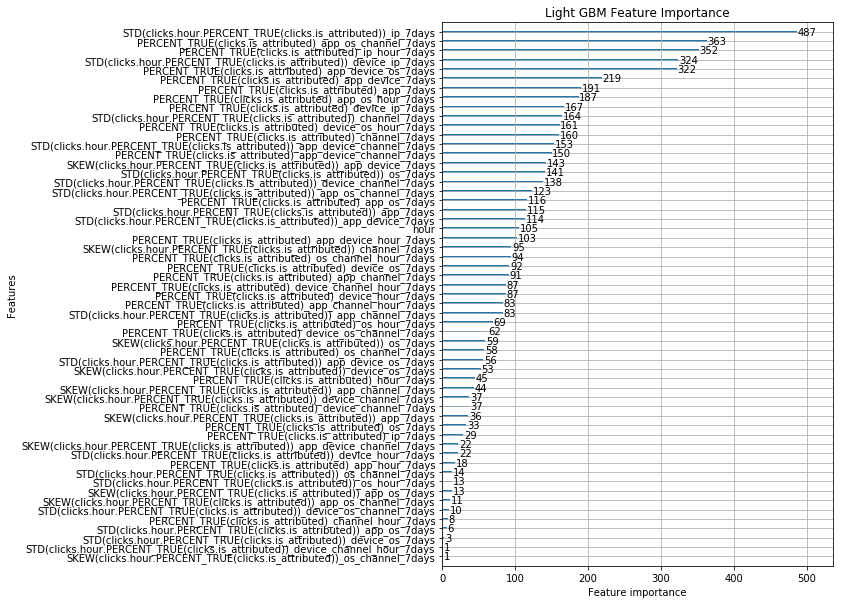

In [17]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=[7,10])
lgb.plot_importance(lgb_model, ax=ax, max_num_features=len(predictors))
plt.title("Light GBM Feature Importance")

In [20]:
import shap

# print the JS visualization code to the notebook
shap.initjs()

In [18]:
nrows = 1000000
X, y = df_train[predictors][:nrows], df_train['is_attributed'][:nrows]

In [21]:
shap_values = shap.TreeExplainer(lgb_model).shap_values(X)

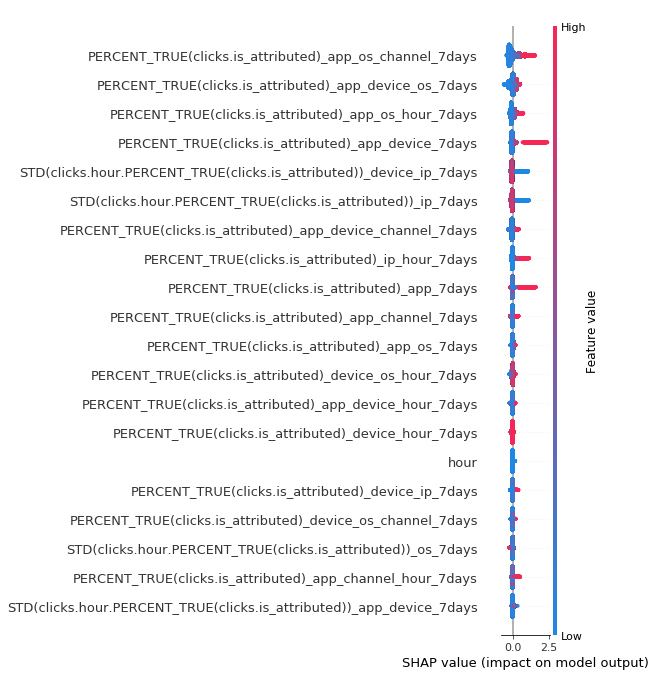

In [22]:
shap.summary_plot(shap_values, X)

In [26]:
shap.force_plot(shap_values[:100,:], X.iloc[:100,:])

In [24]:
shap.force_plot(shap_values[334,:], X.iloc[334,:])

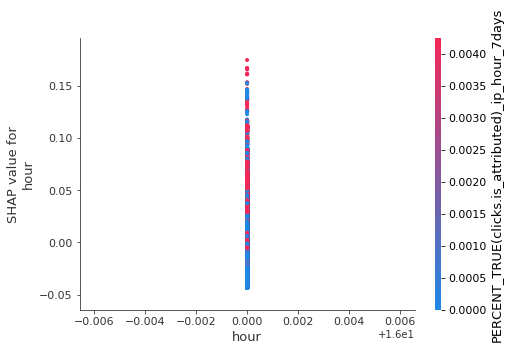

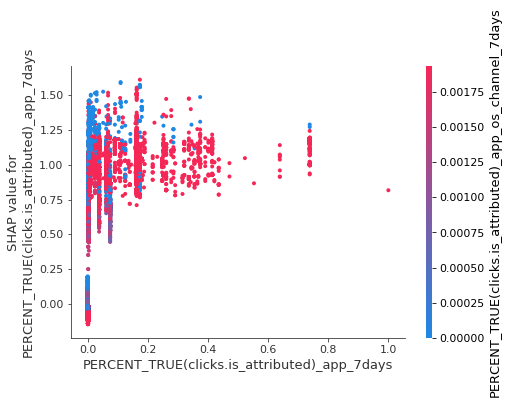

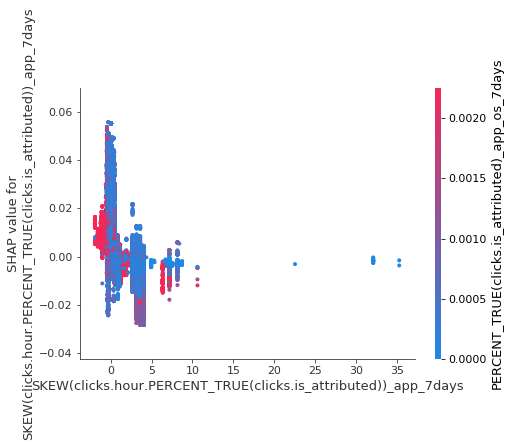

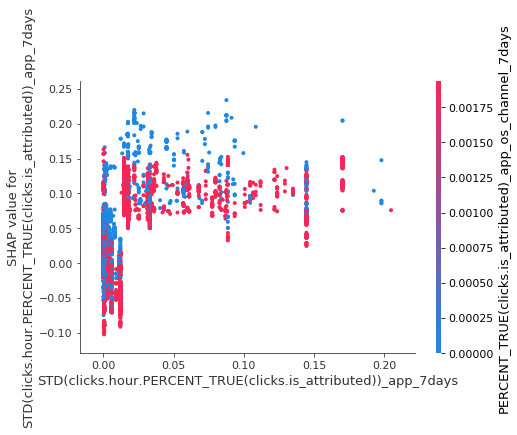

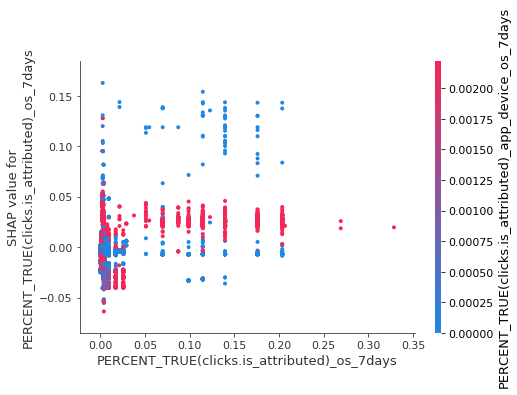

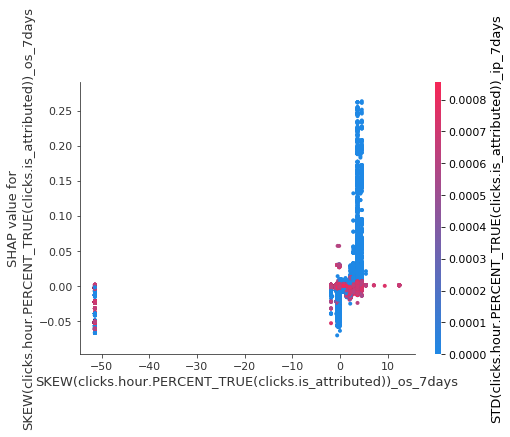

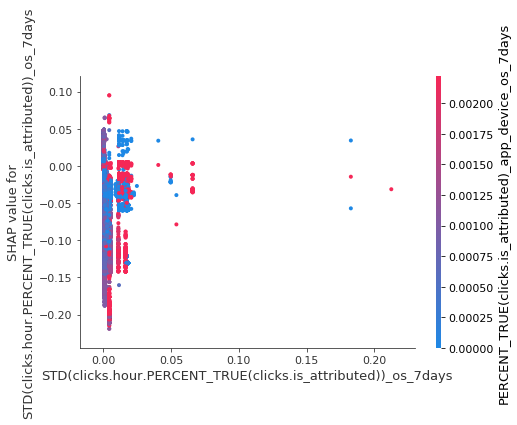

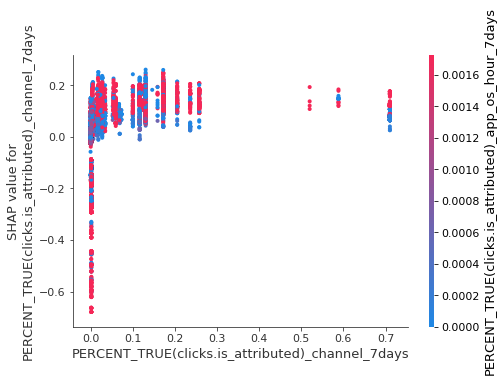

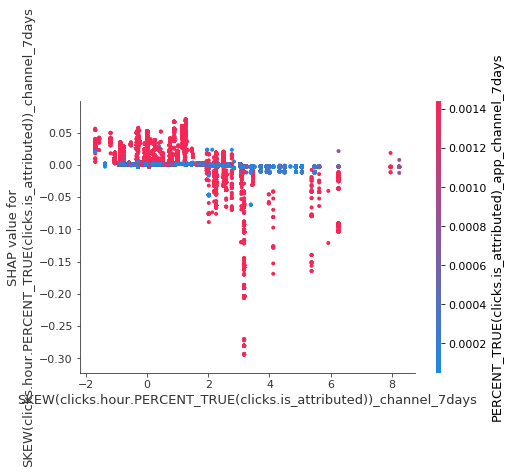

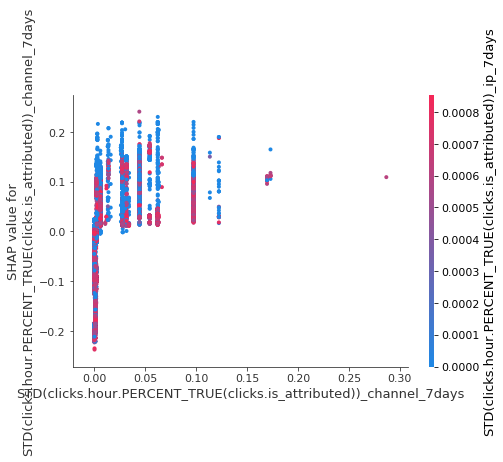

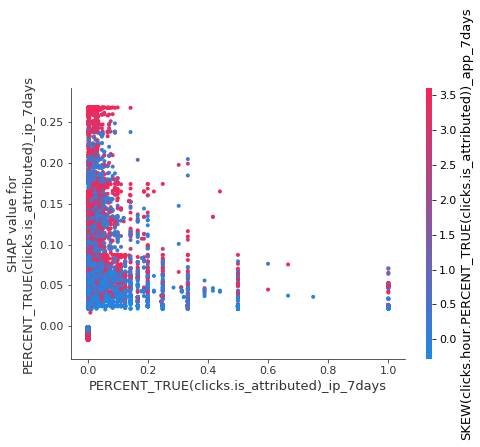

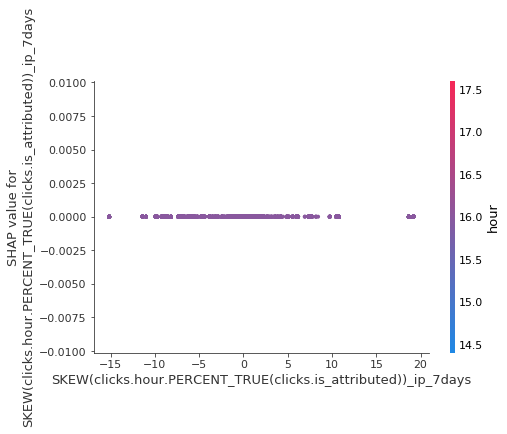

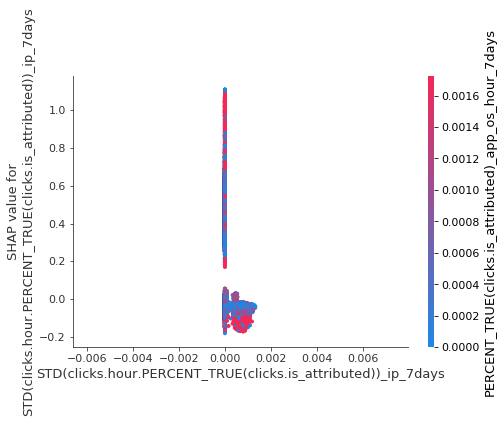

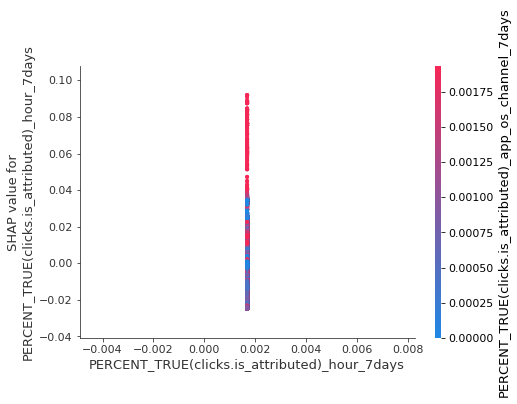

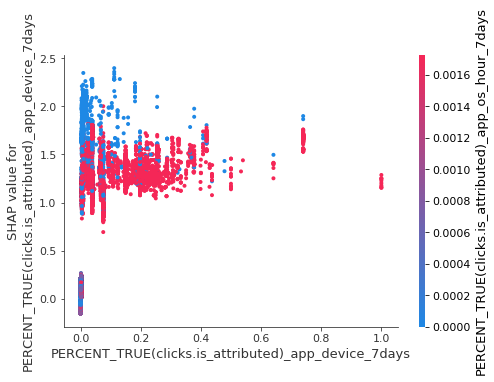

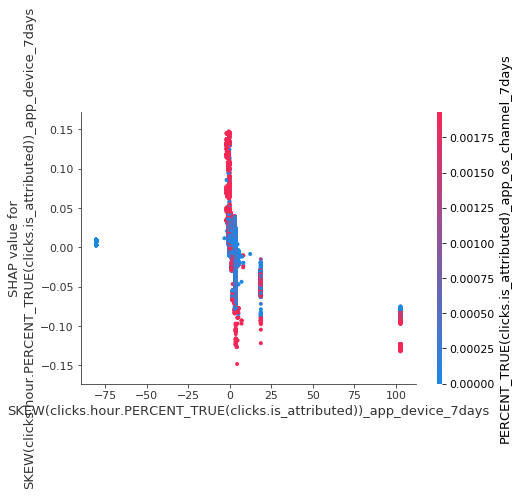

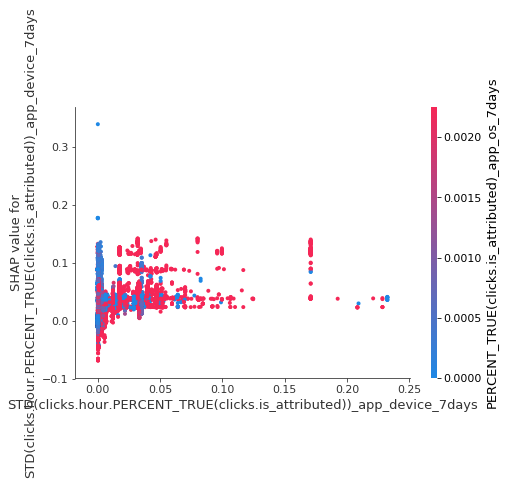

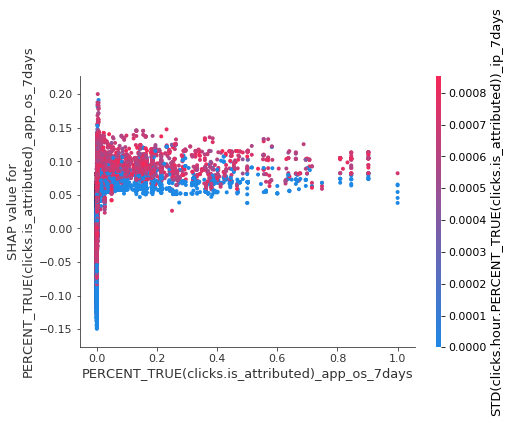

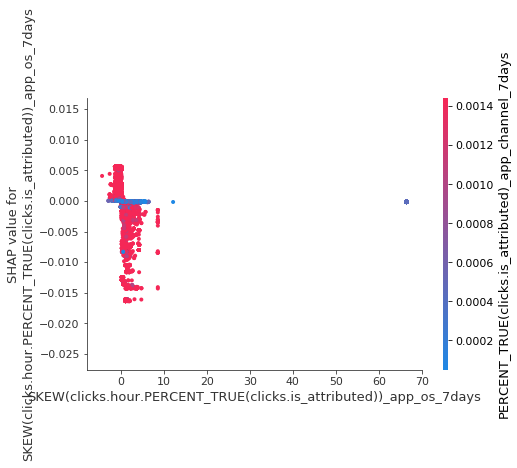

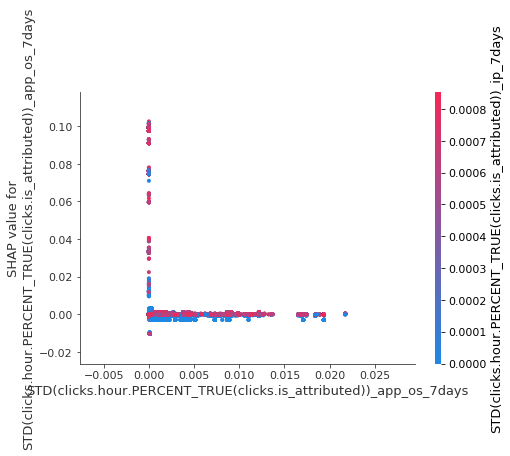

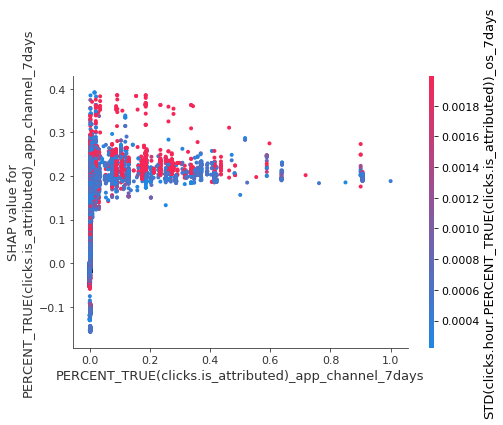

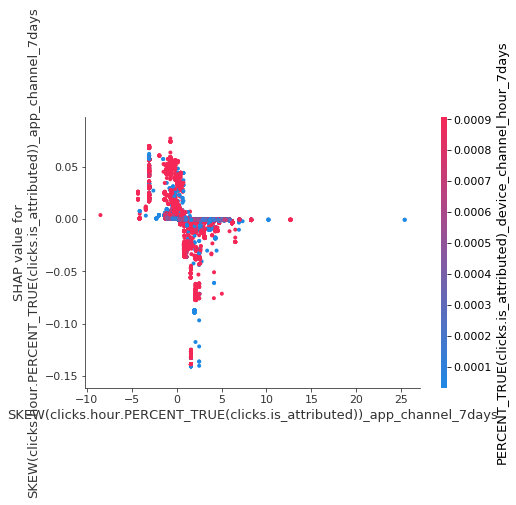

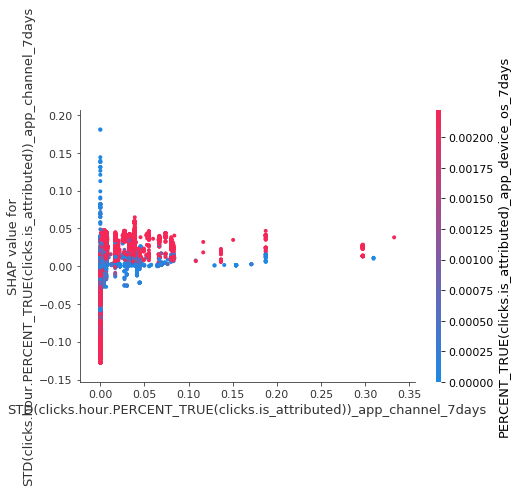

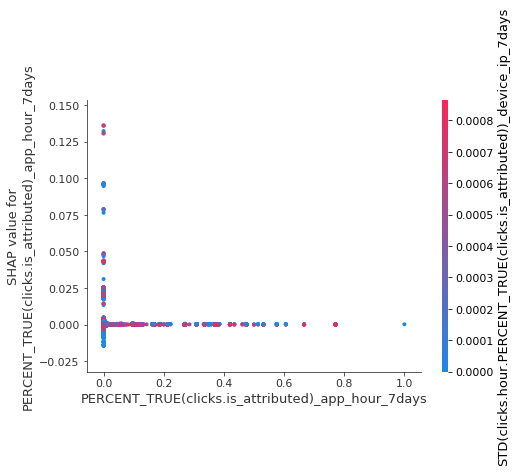

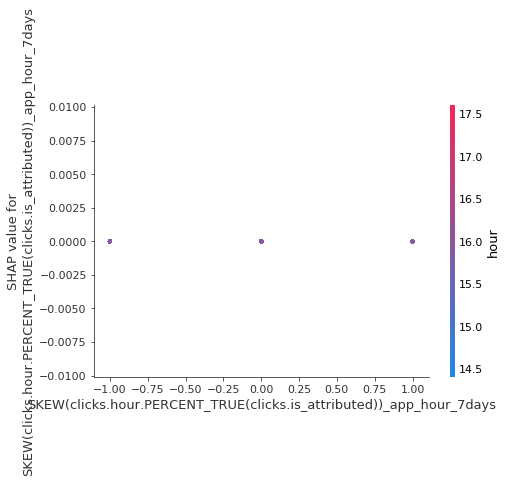

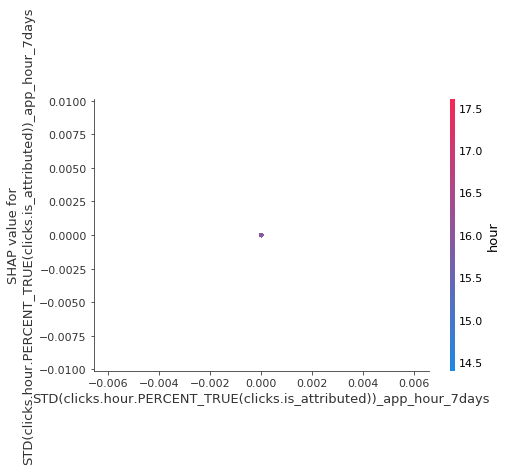

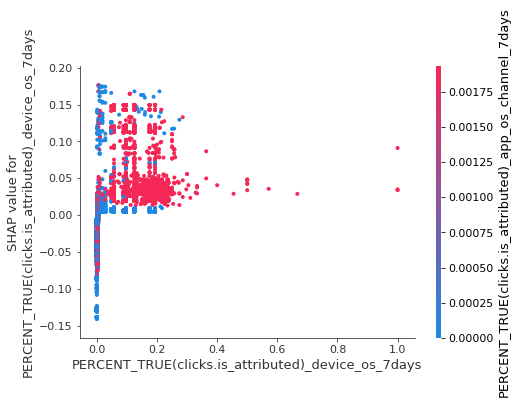

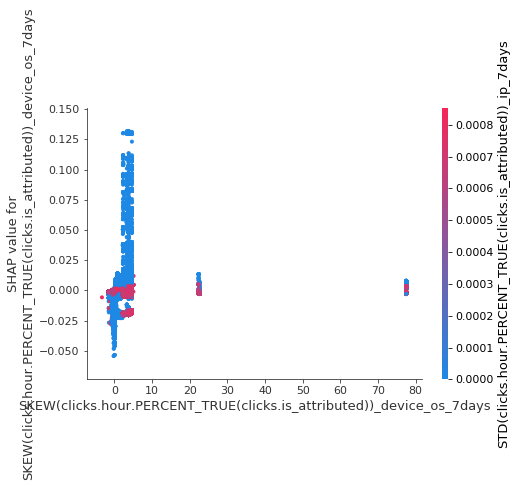

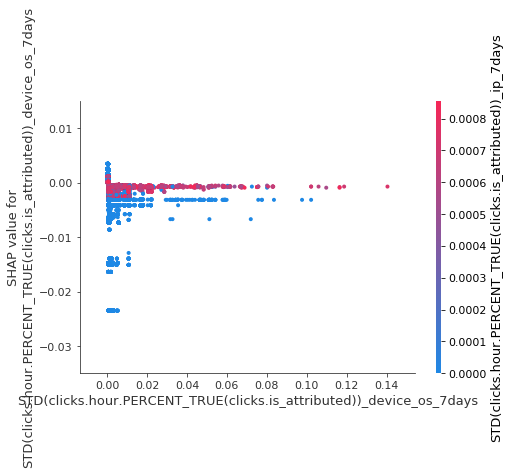

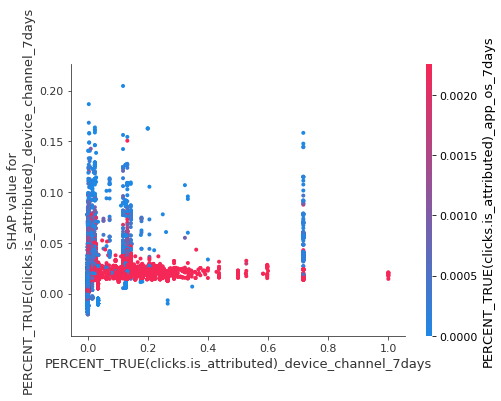

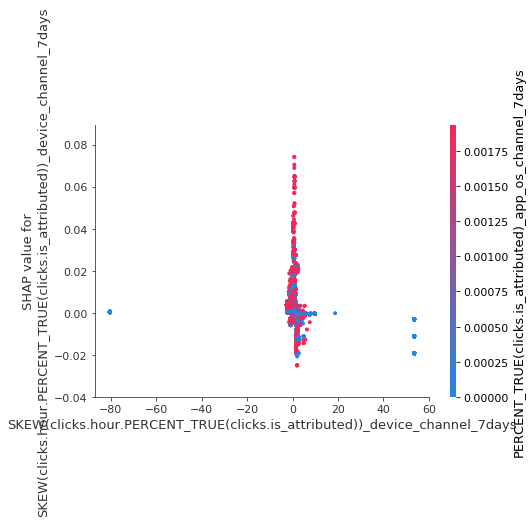

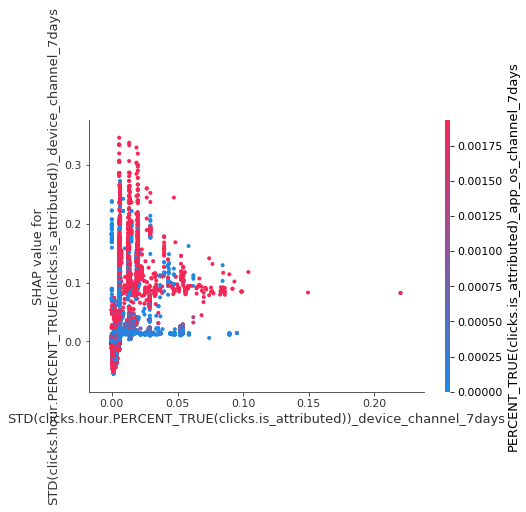

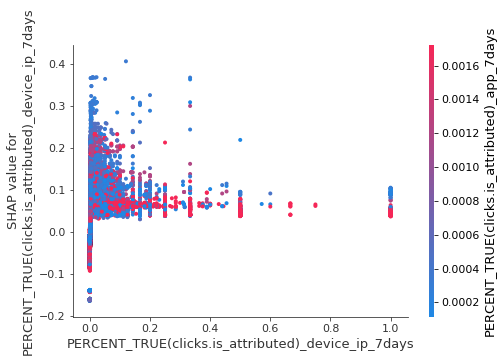

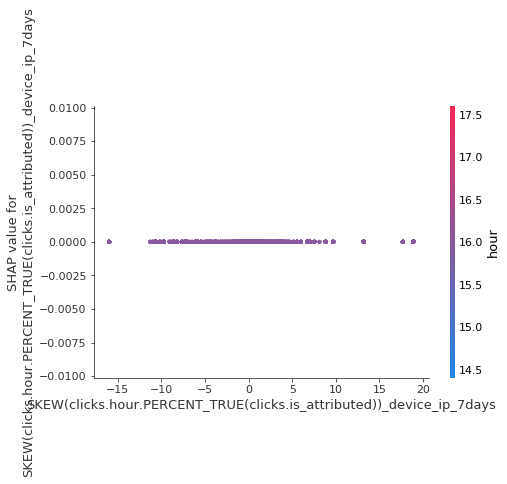

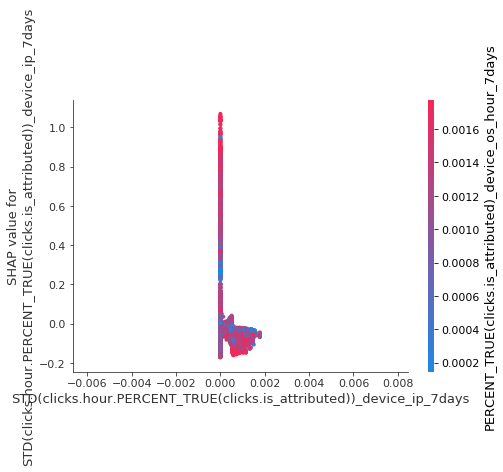

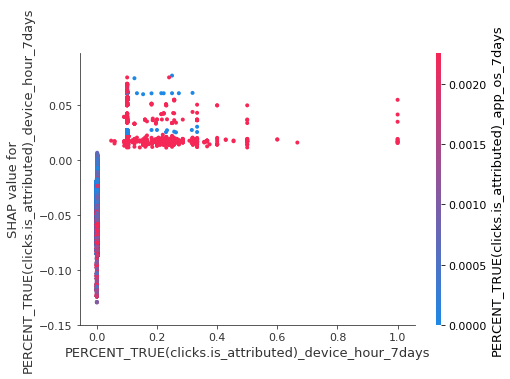

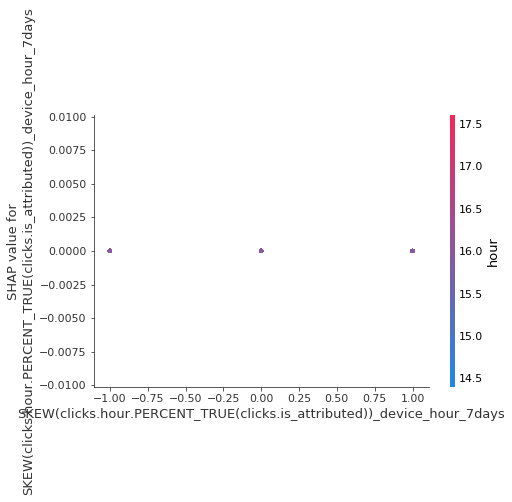

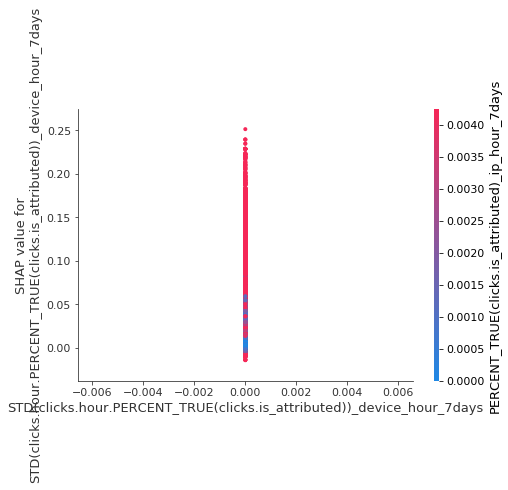

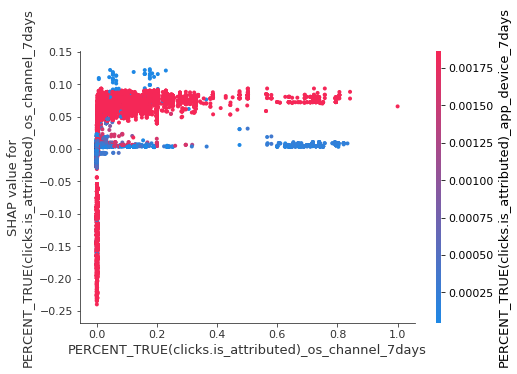

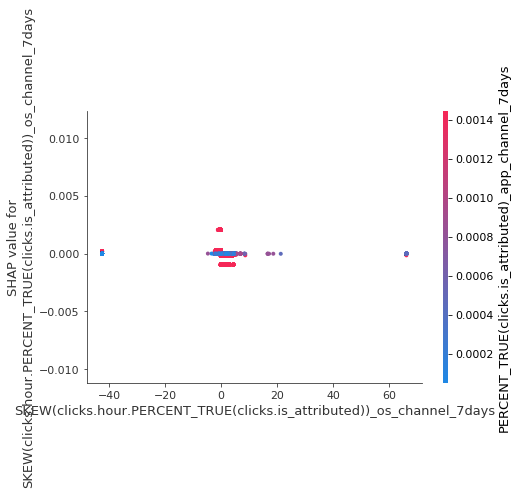

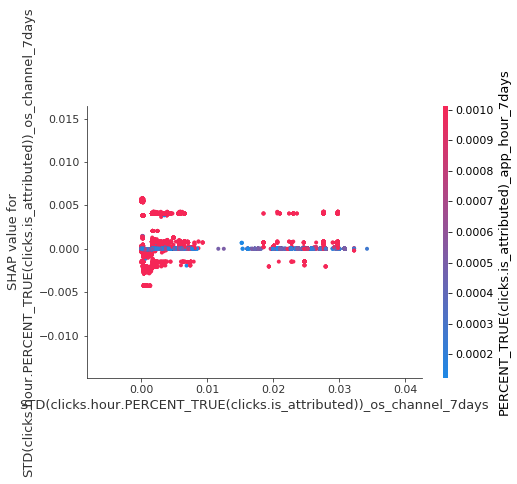

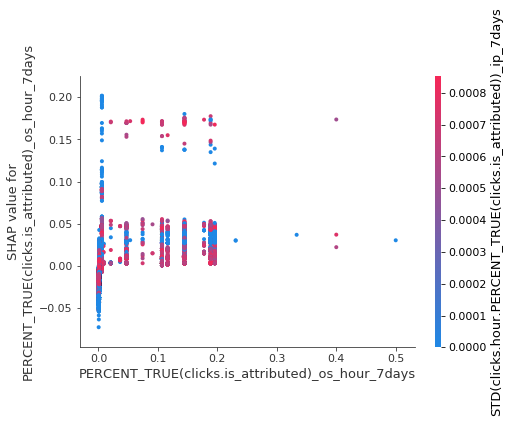

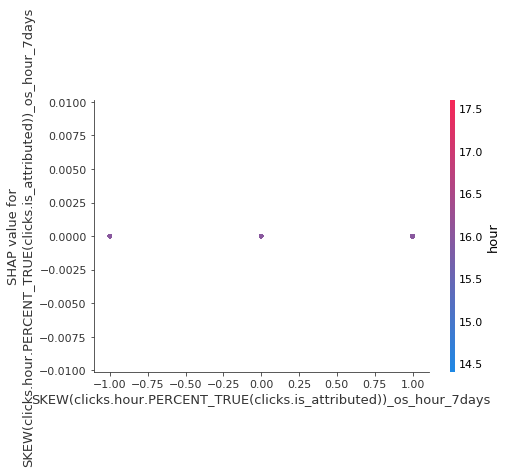

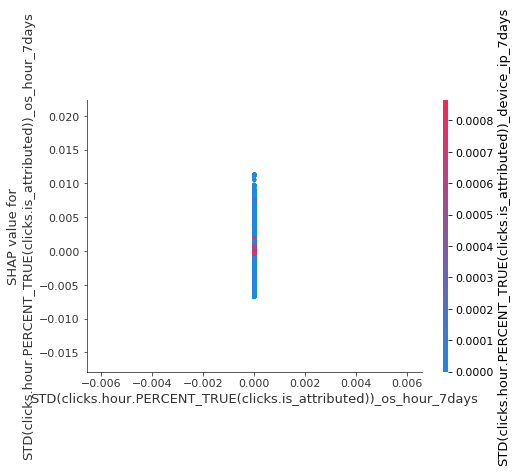

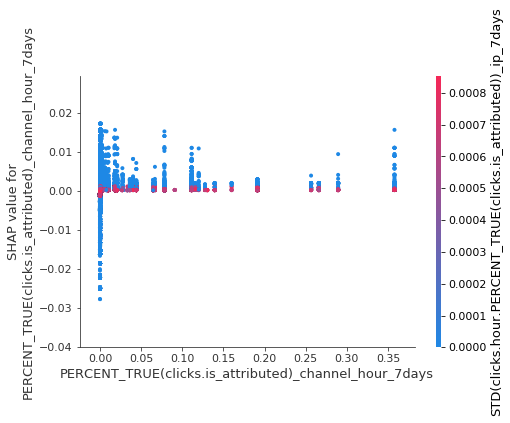

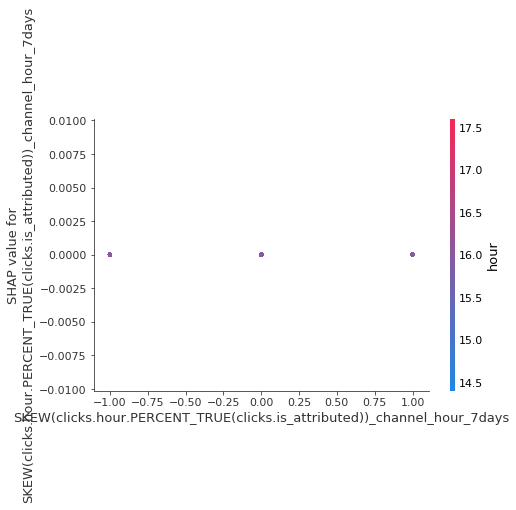

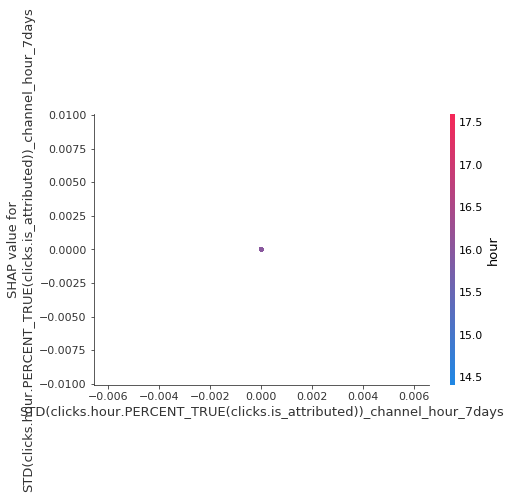

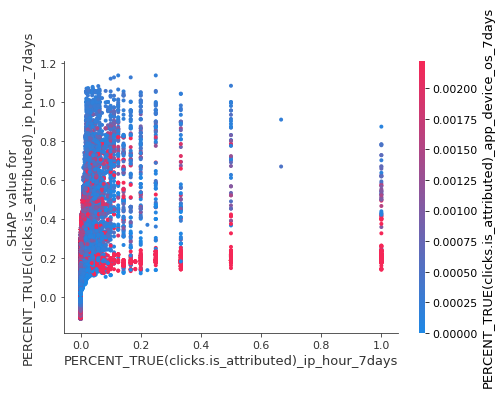

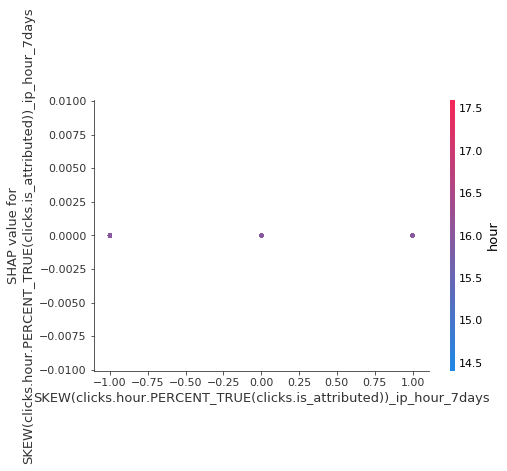

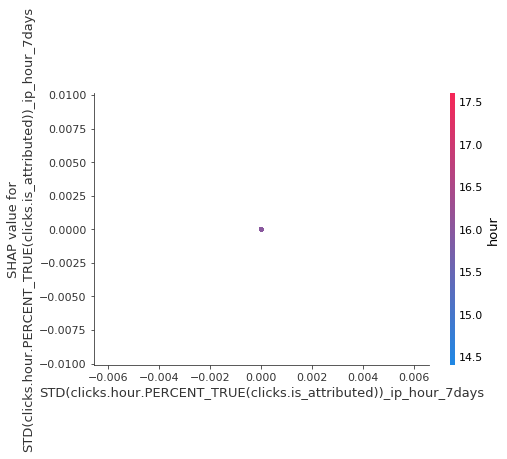

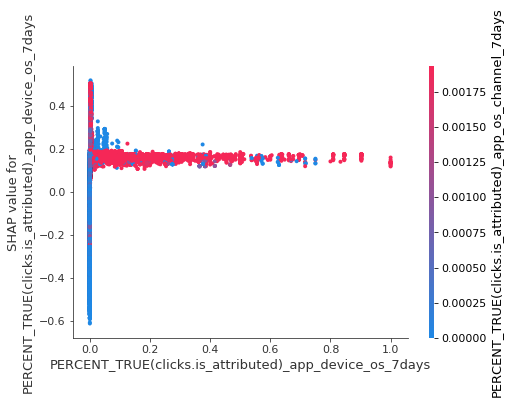

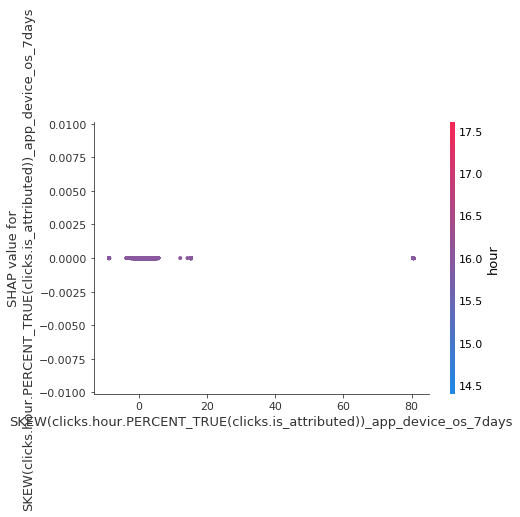

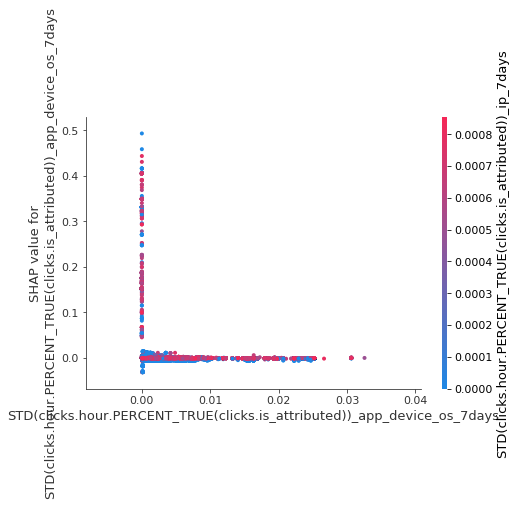

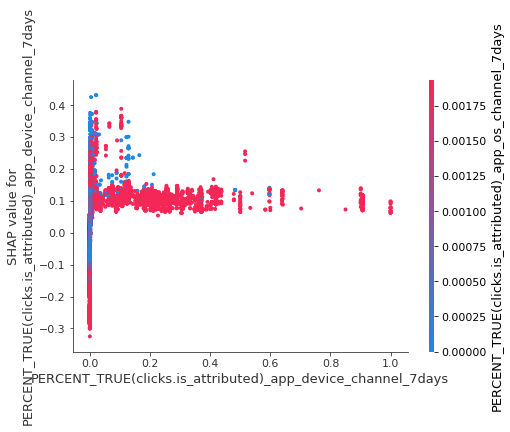

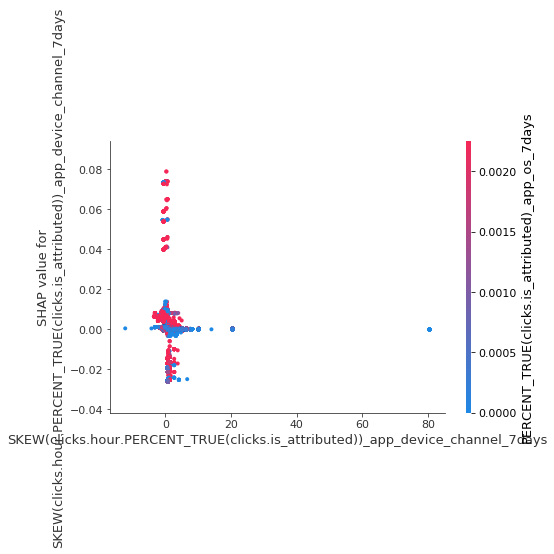

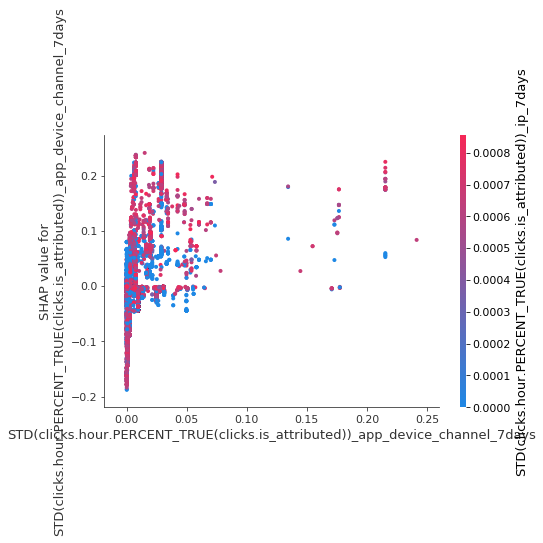

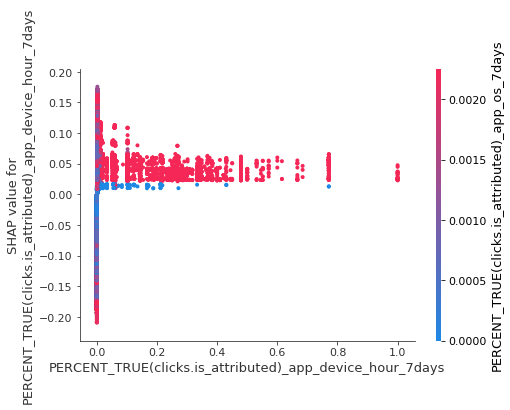

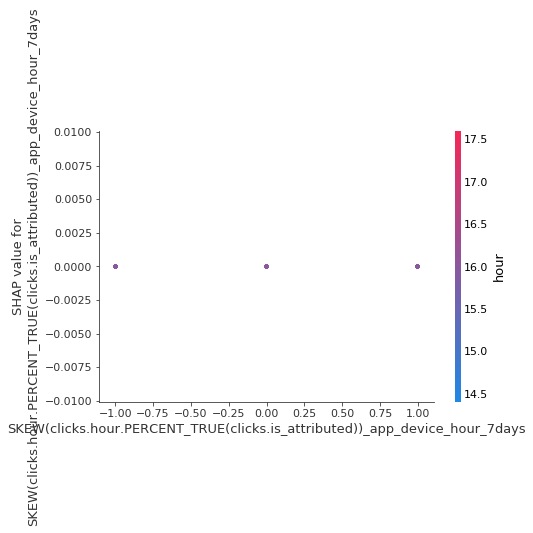

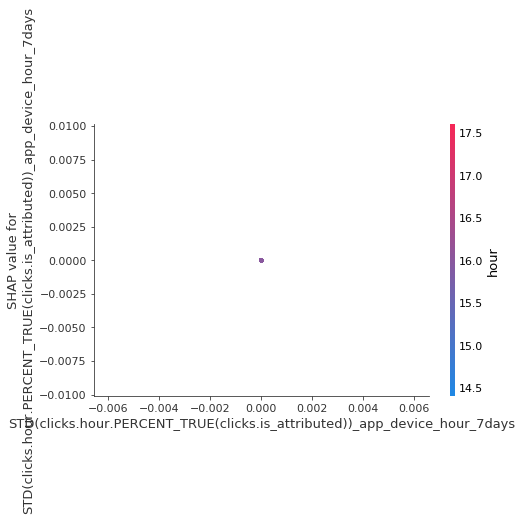

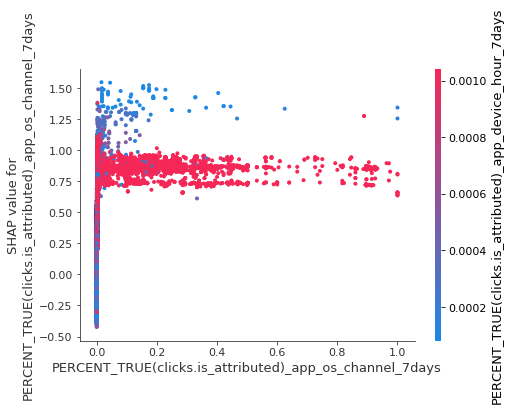

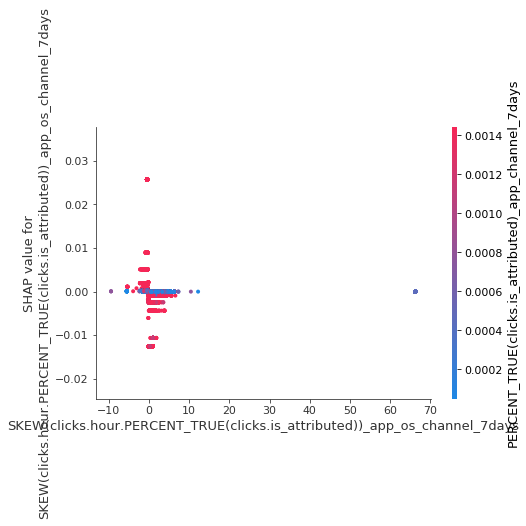

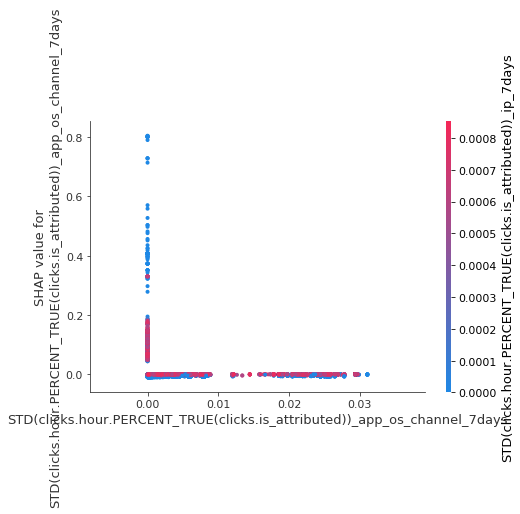

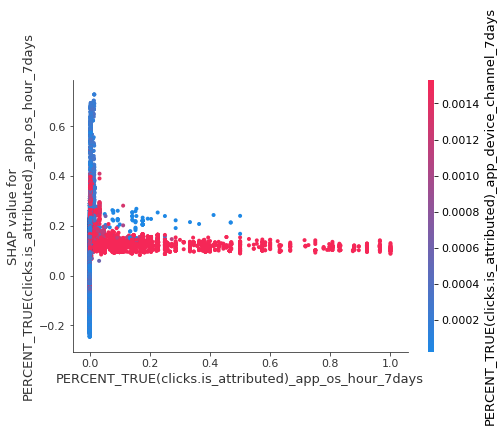

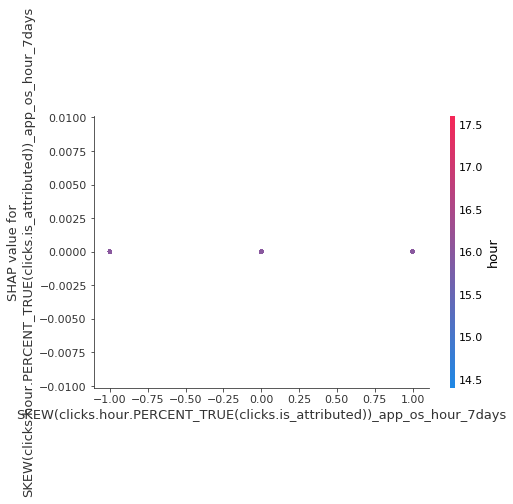

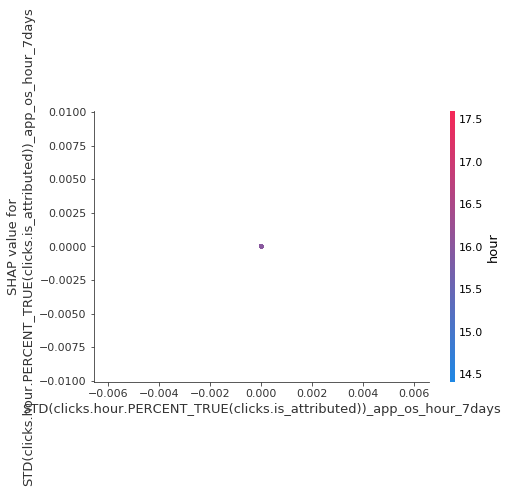

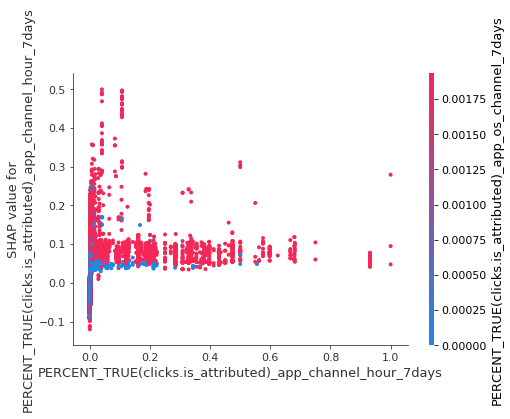

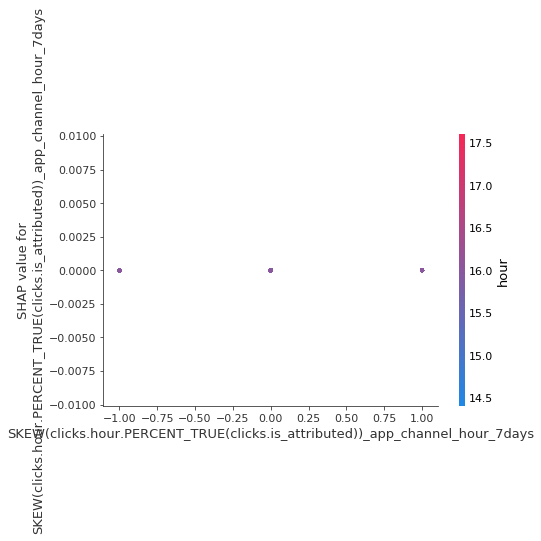

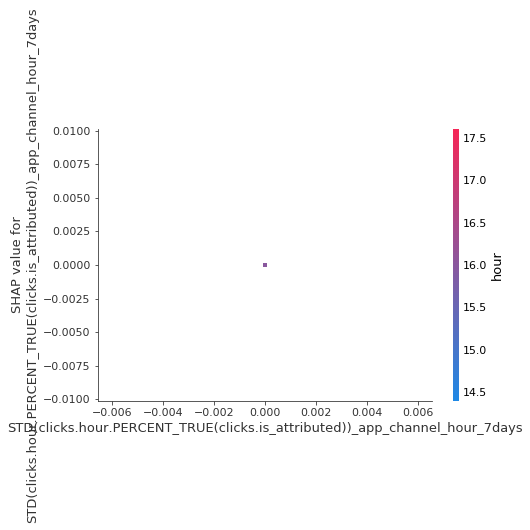

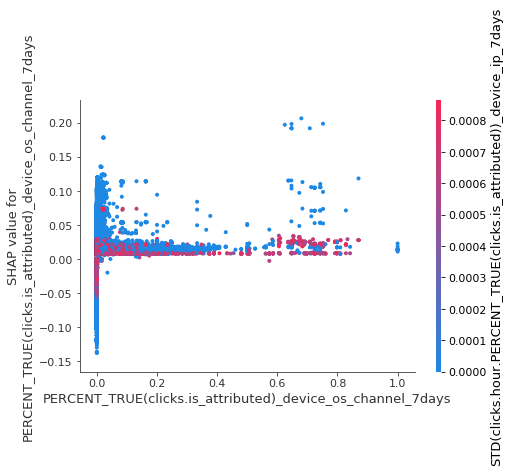

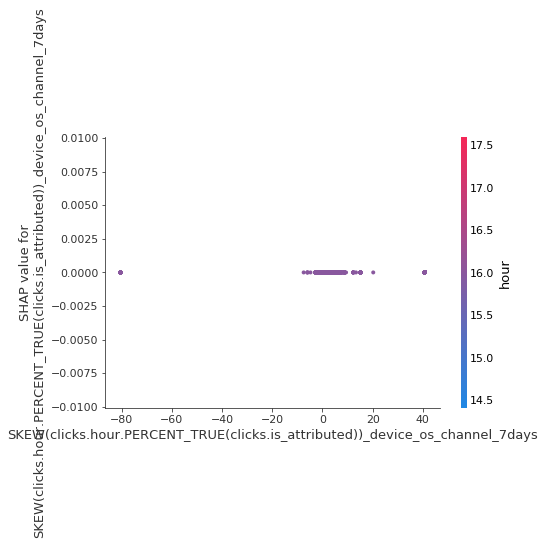

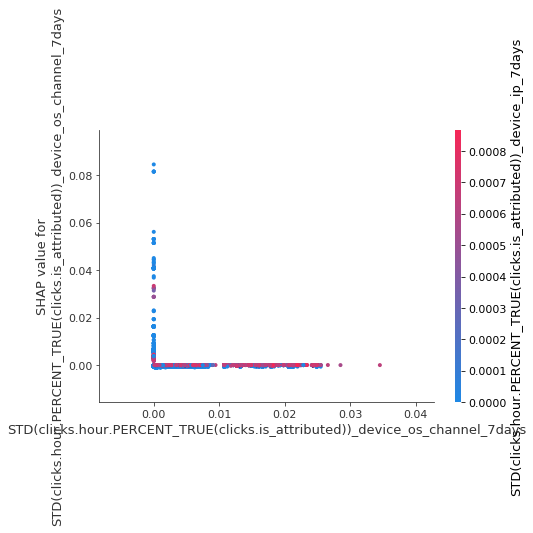

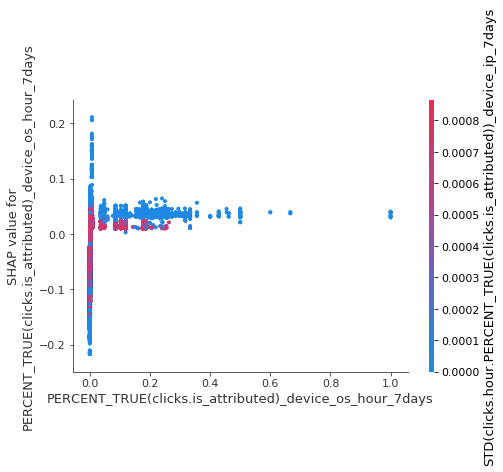

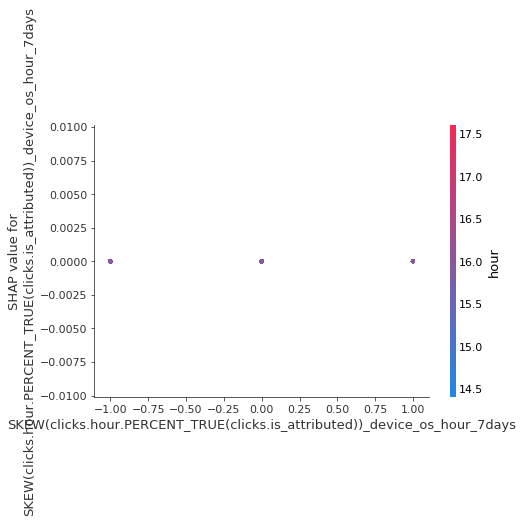

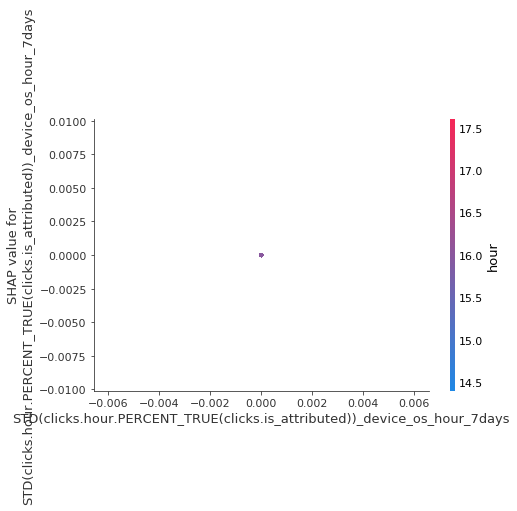

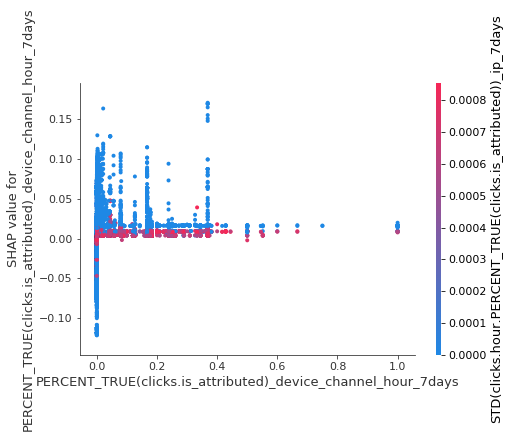

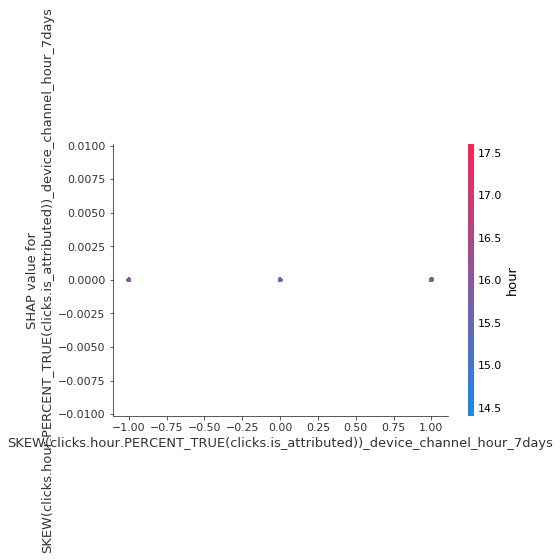

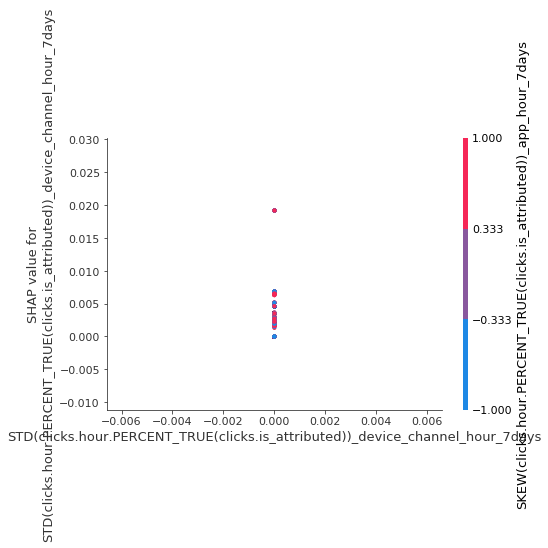

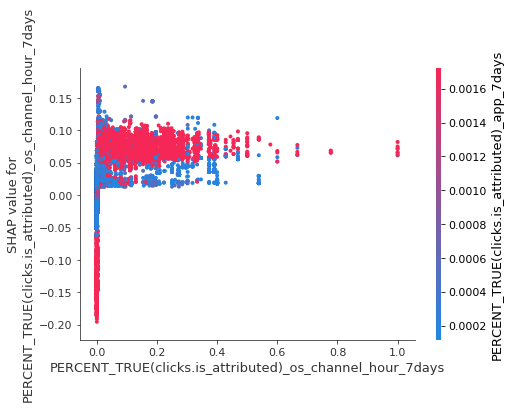

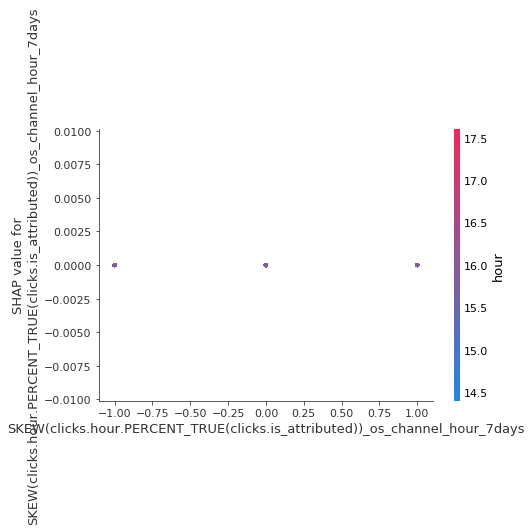

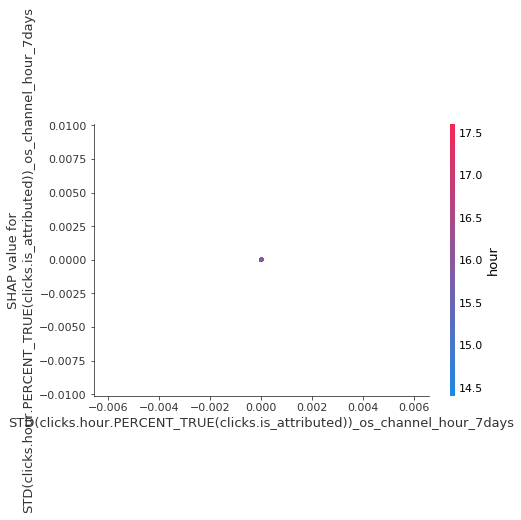

In [25]:
for name in X.columns:
    shap.dependence_plot(name, shap_values, X)

In [ ]:
cache_test = '../data/cache/test_lgbm_2017-11-09.hdf.compress'
if not Path(cache_test).exists() or force:
    print("Test cache doesn't exist, creating")
    df_test = pd.read_hdf('../data/raw/test.hdf.compress')
    df_test = combine_features(df_test, 'features_2017-11-09_1700', 'attributed2')
    df_test.to_hdf(cache_test, 'test', mode='w', complib='blosc', fletcher32=True, complevel=9)
else:
    df_test = pd.read_hdf(cache_test)

In [ ]:
df_sub = pd.DataFrame()
df_sub['click_id'] = df_test['click_id']
df_sub['is_attributed'] = lgb_model.predict(df_test[predictors].values)
df_sub.to_csv('lgbm_attributed_submission.csv', index=False, float_format='%.9f')

In [ ]:
import gzip
import shutil
with open('lgbm_attributed_submission.csv', 'rb') as f_in:
    with gzip.open('lgbm_attributed_submission.csv.gz', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)